In [19]:
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader, Dataset
import numpy as np
from data.gen_signal import build_empty_signal, gauss_sig
from data.gen_noise_spectrum import generate_time_from_psd, f2
import torch
import os

from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generate dataset for classification

In [2]:
def build_toy_dataset(size = 10000, std_min = 10, std_max = 30, amp_min = 1, amp_max = 10, num_pulses = 1, std_length = 3):

    sr = 2**5

    # generate psd first, assuming some binning(anything)
    largest_frequency = 1000
    num_bins = 700
    freqs = np.linspace(0, largest_frequency, num_bins)
    
    # generate spikes of noise
    num_spikes = 10
    psd = np.zeros(num_bins)

    X = []
    Y = []
    for i in range(size):
        psd, freq_spectrum, noise_time = generate_time_from_psd(num_bins*2, sr, largest_frequency, num_bins, f2, {"num_spikes":10})

        x, t = build_empty_signal(noise_time.shape[0], sr)

        if i % 2 == 0:
            sig = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
            X.append(sig + noise_time)
            Y.append(1)
        else:
            X.append(noise_time)
            Y.append(0)
        
    return np.array(X), np.array(Y)

In [3]:
class Toy_loader(Dataset):
    def __init__(self, normalize=True):
        X, y = build_toy_dataset(size = 10000, std_min = 10, std_max = 30, amp_min = 1, amp_max = 10, num_pulses = 1, std_length = 3)
        X = X[:, :, np.newaxis] # to fit the convention of the SSM
        self.timeseries = np.float32(X)
        #self.labels = np.stack([np.float32(~y), np.float32(y)], axis=1)
        #self.labels = np.int32(y)
        self.labels = y
        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        times = self.timeseries[idx, :, :]
        labels = self.labels[idx]
        return times, labels

In [4]:
fulldata = Toy_loader(normalize=True)
generator = torch.Generator().manual_seed(42) 
trainset, valset, testset = torch.utils.data.random_split(fulldata, [0.7,0.1,0.2], generator=generator)

# Dataloaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,

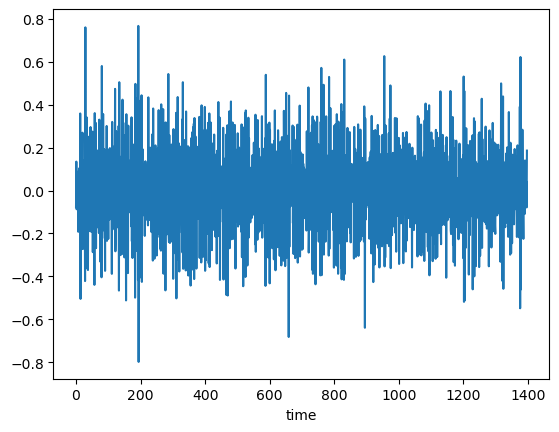

In [12]:
batch = next(iter(train_loader))
plt.plot(batch[0][0].numpy())
plt.xlabel("time")

print((batch[1]))

# Initialize SSM (or alternative) to do classification

In [13]:
from models.s4d import S4D
import torch.nn as nn

d_input = 1
d_output = 2

dropout_fn = nn.Dropout2d

In [14]:
class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()
        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, 0.01))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)
            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)
            # Dropout on the output of the S4 block
            z = dropout(z)
            # Residual connection
            x = z + x
            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x

# Model
print('==> Building model..')
model = S4Model(d_input=1, d_output=d_output, d_model=128, n_layers=4, dropout=0.0, prenorm=False)
model = model.to(device)
print('...done!')

==> Building model..
...done!


In [15]:
import torch.optim as optim
def setup_optimizer(model, lr, weight_decay, epochs):
    """
    S4 requires a specific optimizer setup.

    The S4 layer (A, B, C, dt) parameters typically
    require a smaller learning rate (typically 0.001), with no weight decay.

    The rest of the model can be trained with a higher learning rate (e.g. 0.004, 0.01)
    and weight decay (if desired).
    """

    # All parameters in the model
    all_parameters = list(model.parameters())

    # General parameters don't contain the special _optim key
    params = [p for p in all_parameters if not hasattr(p, "_optim")]

    # Create an optimizer with the general parameters
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    # Add parameters with special hyperparameters
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    # Create a lr scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

    # Print optimizer info
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

criterion = nn.CrossEntropyLoss()
optimizer, scheduler = setup_optimizer(
    model, lr=0.01, weight_decay=0.01, epochs=10
)

Optimizer group 0 | 28 tensors | lr 0.01 | weight_decay 0.01
Optimizer group 1 | 12 tensors | lr 0.001 | weight_decay 0.0


# Actual training (standard torch)

In [16]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [22]:
# Training
def train():
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(train_loader))
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
            (batch_idx, len(train_loader), train_loss/(batch_idx+1), 100.*correct/total, correct, total)
        )


def eval(epoch, dataloader, checkpoint=False):
    global best_acc
    model.eval()
    eval_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_description(
                'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
                (batch_idx, len(dataloader), eval_loss/(batch_idx+1), 100.*correct/total, correct, total)
            )

    # Save checkpoint.
    if checkpoint:
        acc = 100.*correct/total
        if acc > best_acc:
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_acc = acc

        return acc

pbar = tqdm(range(start_epoch, 10))
for epoch in pbar:
    if epoch == 0:
        pbar.set_description('Epoch: %d' % (epoch))
    else:
        pbar.set_description('Epoch: %d | Val acc: %1.3f' % (epoch, val_acc))
    train()
    val_acc = eval(epoch, valid_loader, checkpoint=True)
    eval(epoch, test_loader)
    scheduler.step()
    # print(f"Epoch {epoch} learning rate: {scheduler.get_last_lr()}")

Epoch: 0:   0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
Batch Idx: (0/14) | Loss: 0.004 | Acc: 100.000% (512/512): : 0it [00:00, ?it/s]
Batch Idx: (0/14) | Loss: 0.004 | Acc: 100.000% (512/512): : 1it [00:00,  1.86it/s]
Batch Idx: (1/14) | Loss: 0.005 | Acc: 100.000% (1024/1024): : 1it [00:01,  1.86it/s]
Batch Idx: (1/14) | Loss: 0.005 | Acc: 100.000% (1024/1024): : 2it [00:01,  1.91it/s]
Batch Idx: (2/14) | Loss: 0.005 | Acc: 100.000% (1536/1536): : 2it [00:01,  1.91it/s]
Batch Idx: (2/14) | Loss: 0.005 | Acc: 100.000% (1536/1536): : 3it [00:01,  1.93it/s]
Batch Idx: (3/14) | Loss: 0.006 | Acc: 99.902% (2046/2048): : 3it [00:02,  1.93it/s] 
Batch Idx: (3/14) | Loss: 0.006 | Acc: 99.902% (2046/2048): : 4it [00:02,  1.94it/s]
Batch Idx: (4/14) | Loss: 0.017 | Acc: 99.922% (2558/2560): : 4it [00:02,  1.94it/s]
Batch Idx: (4/14) | Loss: 0.017 | Acc: 99.922% (2558/2560): : 5it [00:02,  1.94it/s]
Batch Idx: (5/14) | Loss: 0.017 | Acc: 99.805% (3066/3072): : 5it [00:03,  1.94it/s

In [20]:
outputs

NameError: name 'outputs' is not defined